# Notes

This notebook is an example of a PRE-PROCESSING pipeline for satellite images with LAI data.
It is not meant to be run as a script, but rather to be used as a reference for how to use the preprocessing functions.

**IMPORTANT** This notebook assumes one has stored a series of *unpacked* RAS and RHD files in the VISTA format containing 
- The Leaf Area Index (LAI) values as a tensor of images over time.
- The scene classification layer (SCL) of the above images.
- Information of the datetimes and the coordinates of the images. 

The VISTA format is not publicly available, but the functions in this notebook can be used as a reference for how to preprocess satellite images in general.

*Example scenario*: We have downloaded the RAS and RHD files containing the LAI values for a sentinel-2 tile (~12k by 12k image) over the span of 2020. We want to preprocess this data for segmentation of fields.

*Author*: Jens d'Hondt (TU Eindhoven)

In [1]:
# General imports
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sys
from eolearn.core import EOPatch

# 0 Unpacking the data (optional)

This step is optional for when one had not yet unpacked the VISTA zips containing the RAS and RHD files with LAI values into a series of .npy files, named by the date of the image.
(e.g. `2020_1_1.npy`, `2020_1_2.npy`, ...) 
The unpacking can be done using the `unpack_vista` function in `src/pipeline/preprocessing/vista.py`, as shown below.

**Assumptions**:
- One has downloaded the VISTA zips and stored them in a folder `$DATADIR`.
- The zip is named `LAI.zip` and contains a series of RAS and RHD files named by the tile_id, and the date, month or year of the data in the image (e.g. `30TYQ_LAI_2022.RHD`, `30TYQ_LAI_2022.RAS`, ...).
- Those RAS and RHD files can contain multiple images, each with a different date, month or year.

**Process**:
The function `unpack_vista` will do the following:
1. Unzip the zip files in `$DATADIR` for each specified band.
2. For each unzipped RAS and RHD file, extract the images and store them in a series of .npy files named by the date of the individual image.

In [2]:
from pipeline.src.preprocessing.vista_preprocessing import unpack_vista

bands = ['LAI']

# DATADIR = "FILL IN PATH HERE"
DATADIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example"

unpack_vista(DATADIR, bands)

Band LAI already unzipped


# 1 Combining images to eopatches

In this step we will combine the individual LAI images into a tensor, or package of images. 

**Assumptions**:
- One has stored the .npy files containing the images in a folder `$DATADIR` following the structure `DATADIR/LAI/{date}.npy`.

**Process**:
The function `combine_bands` will do the following:
1. Partition the .npy files into a series of EOPatches, each containing a tensor of images, the corresponding datetimes and bounding box.

In [2]:
from pipeline.src.preprocessing.preprocessing import combine_npys_to_eopatch, max_partition_size
import math

# The selection of dates we want to use for segmentation
DATADIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example"

npy_files = glob.glob(os.path.join(DATADIR, "LAI","*.npy"))
max_partition_size = max_partition_size(npy_files[0], MAX_RAM=4 * 1e9)

eopatch = combine_npys_to_eopatch(datadir=DATADIR, 
                        eopatch_name="lai_eopatch",
                        feature_name="LAI",
                        bands=['LAI'],
                        derive_mask=False,
                        delete_after=False,
                        partition_size=max_partition_size,
                        )
eopatch

Processing 14 partitions of 19 dates each


EOPatch(
  data: {
    LAI: numpy.ndarray(shape=(18, 10002, 10002, 1), dtype=int16)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((704855.0, 4995145.0), (804875.0, 5095165.0)), crs=CRS('32630'))
  timestamp: [datetime.datetime(2022, 10, 7, 0, 0), ..., datetime.datetime(2022, 12, 31, 0, 0)], length=18
)

# 2 LAI to CSV

In this step we will convert the LAI values to a timeseries of LAI values for each pixel OR field (extracted in the segmentation pipeline).
The conversion into timeseries will be done per image.

The values for collections of pixels and/or fields will be stored as column-major csv file with pixel/field ids as columns, and dates as rows. This is to facilitate appending of new data.
The values for pixels will be partitioned by *patchlets*, which are subsets of the full image. This is done to reduce the size of the csv files.

**Assumptions**:
- One has stored the EOPatch objects in a folder `$DATADIR` following the structure `DATADIR/lai_eopatch/lai_eopatch_{start_date}` (see step 1).

## 2.1 LAI to CSV: pixel values

### 2.1.2 Approach 1: npys -> eopatches -> p patchlets per date -> p patchlets -> timeseries

**Process**:
The function `lai_to_csv_px` will do the following:

0. Turn each image into an eopatch (see step 1).
1. We break up each image into a series of patchlets.
2. We combine the data for each patchlet into a single eopatch.
3. We convert the eopatch into a timeseries of LAI values for each pixel.
4. (Optional) Combine the timeseries of LAI values for each pixel into a single csv file.

In [2]:
from src.preprocessing.timeseries import lai_to_csv_px

DATADIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example"
eop_paths = glob.glob(os.path.join(DATADIR, "lai_eopatch", "*"))
patchlet_dir = os.path.join(DATADIR, "patchlets", "lai")
outdir = os.path.join(DATADIR, "lai_px_timeseries")

# Turn the LAI values into a csv file
lai_to_csv_px(eop_paths, patchlet_dir=patchlet_dir, outdir=outdir, delete_patchlets=True)

1. Splitting tiles into patchlets


100%|██████████| 14/14 [17:41<00:00, 75.84s/it]


2. Combining dates per patchlet


100%|██████████| 81/81 [05:22<00:00,  3.99s/it]


3. Extracting time series from each patchlet


### 2.1.2 Approach 2: Iterative approach to building the timeseries

**Process**:
The function `lai_to_csv_px_iterative` will do the following:
- For each image:
    1. Load the LAI values.
    2. Append the LAI value for each pixel to the corresponding csv file in parallel.

In [24]:
def initialize_lai_csv(csv_path:str):
    with open(csv_path, "w") as f:
        f.write("datetime,value\n")

def append_lai_csv(csv_path:str, datetime:dt.datetime, value:float):
    with open(csv_path, "a") as f:
        f.write(f"{datetime},{value}\n")

def save_lai_to_csv(xy_value:tuple, outdir:str, tile_id:str, datetime:dt.datetime):
    x,y,value = xy_value
    csv_path = get_px_csv_path(outdir, tile_id, str(x), str(y))
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    if not os.path.exists(csv_path):
        initialize_lai_csv(csv_path)
    append_lai_csv(csv_path, datetime, value)

def save_lai_to_csv_chunk(xy_values:list, outdir:str, tile_id:str, datetime:dt.datetime):
    for xy_value in xy_values:
        save_lai_to_csv(xy_value, outdir, tile_id, datetime)

In [4]:
from src.lib import multiprocess_map

def save_lai_csv(npy_path:str, outdir:str, tile_id:str = "30TYQ", n_jobs:int = 4):
    # Load the npy file into memory
    LAI = np.load(npy_path)

    # Get the datetime from the filename
    datetime = dt.datetime.strptime(os.path.basename(npy_path).replace(".npy", ""), "%Y_%m_%d")

    # Get good px values
    pxdf = get_good_px_df(LAI)

    # Process the px values in chunks in parallel
    CHUNK_SIZE = 1_000_000

    # Turn pxdf into a list of tuples
    pxdf = pxdf.to_records(index=False).tolist()

    # Divide the px values into chunks
    chunks = [pxdf[i:i+CHUNK_SIZE] for i in range(0, len(pxdf), CHUNK_SIZE)]

    # Save the px values to csv in parallel
    multiprocess_map(save_lai_to_csv_chunk, chunks, outdir=outdir, tile_id=tile_id, datetime=datetime, n_jobs=n_jobs)

In [5]:
DATADIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example"

npys = glob.glob(os.path.join(DATADIR, "LAI", "*.npy"))
npys.sort()

save_lai_csv(npys[0], DATADIR, n_jobs=8)

  0%|          | 0/57 [01:03<?, ?it/s]


KeyboardInterrupt: 

## 2.2 LAI to CSV: field values

**Process**:
The function `lai_to_csv_field` will do the following:

1. Temporarily save the (partitioned) eopatches as tiffs (necessary for masking with field shapes)
2. For each tiff:
    1. Load the LAI values.
    2. For each field:
        1. Mask the LAI values for the field.
        2. Take the median of the LAI values for the field for each date.
        3. Append the LAI values for the field to the corresponding csv file.
3. (Optional) Combine the timeseries of LAI values for each pixel into a single csv file.

In [3]:
from src.preprocessing.timeseries import lai_to_csv_field

DATADIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example"
eop_paths = glob.glob(os.path.join(DATADIR, "lai_eopatch", 'lai_eopatch_*'))
eop_paths.sort()
fields_path = os.path.join(DATADIR, "fields.gpkg")

# Perform the process as described above
lai_to_csv_field(eop_paths, fields_path=fields_path, outdir=DATADIR, n_jobs=16, delete_tmp=False)

Processing eopatch 1/14


100%|██████████| 83198/83198 [17:38<00:00, 78.64it/s] 


Done
Processing eopatch 2/14s


100%|██████████| 83198/83198 [17:17<00:00, 80.16it/s] 


Done
Processing eopatch 3/14s


100%|██████████| 83198/83198 [16:29<00:00, 84.07it/s] 


Done
Processing eopatch 4/14s


100%|██████████| 83198/83198 [17:33<00:00, 78.98it/s] 


Done
Processing eopatch 5/14s


100%|██████████| 83198/83198 [17:10<00:00, 80.75it/s] 


Done
Processing eopatch 6/14s


100%|██████████| 83198/83198 [16:50<00:00, 82.30it/s] 


Done
Processing eopatch 7/14s


100%|██████████| 83198/83198 [17:07<00:00, 81.00it/s] 


Done
Processing eopatch 8/14s


100%|██████████| 83198/83198 [15:57<00:00, 86.87it/s] 


Done
Processing eopatch 9/14s


100%|██████████| 83198/83198 [16:13<00:00, 85.46it/s] 


Done
Processing eopatch 10/14


100%|██████████| 83198/83198 [16:17<00:00, 85.14it/s] 


Done
Processing eopatch 11/14


100%|██████████| 83198/83198 [16:30<00:00, 83.96it/s] 


Done
Processing eopatch 12/14


100%|██████████| 83198/83198 [16:23<00:00, 84.56it/s] 


Done
Processing eopatch 13/14


100%|██████████| 83198/83198 [15:57<00:00, 86.86it/s] 


Done
Processing eopatch 14/14


100%|██████████| 83198/83198 [16:12<00:00, 85.59it/s] 


Done


In [14]:
# Read csv file
csv_path = os.path.join(DATADIR, "lai_field_timeseries.csv")
df_field = pd.read_csv(csv_path, index_col=0)

df_field.head()

ERROR 1: /home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example/tmp.tiff, band 10: An error occurred while writing a dirty block from FlushCache
ERROR 1: /home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example/tmp.tiff, band 11: An error occurred while writing a dirty block from FlushCache
ERROR 1: /home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example/tmp.tiff, band 12: An error occurred while writing a dirty block from FlushCache
ERROR 1: /home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example/tmp.tiff, band 13: An error occurred while writing a dirty block from FlushCache
ERROR 1: /home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example/tmp.tiff, band 14: An error occurred while writing a dirty block from FlushCache
ERROR 1: /home/jens/ownCloud/D

,0,3,4,5,6,7,8,9,10,11,...,91986,91987,91988,91989,91990,91991,91992,91993,91994,91996
2021-07-17,928.0,5310.0,2698.0,292.0,244.5,3438.0,289.0,3688.0,3528.0,489.0,...,3474.0,5650.0,NaN,5452.0,4390.0,5400.0,727.0,5616.0,3134.0,1734.0
2021-07-19,638.0,4780.0,2724.0,253.5,247.0,3124.0,257.0,3416.0,3326.0,481.0,...,3492.0,5220.0,NaN,4916.0,4130.0,4996.0,552.0,5188.0,2912.0,1575.0
2021-07-22,808.0,4910.0,2634.0,301.0,566.0,3066.0,366.0,3300.0,3162.0,521.0,...,2496.0,3058.0,NaN,3728.0,3538.0,1462.0,1019.0,2822.0,2510.0,1811.0
2021-07-24,NaN,NaN,NaN,287.0,560.5,NaN,NaN,NaN,NaN,NaN,...,NaN,3746.0,NaN,NaN,NaN,NaN,346.0,NaN,2280.0,3250.0
2021-08-08,NaN,2844.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3252.0,NaN,NaN,NaN,2796.0,399.0,5000.0,1872.0,1744.0


<Axes: >

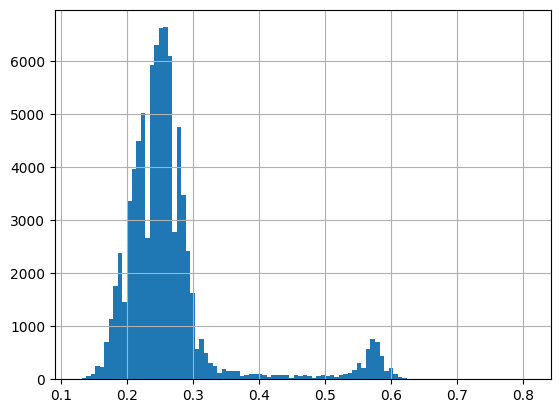

In [16]:
df_field.isna().mean(axis=0).hist(bins=100)

In [7]:
csv_path = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example/lai_px_timeseries/patchlet_0_0.csv.gz"

df = pd.read_csv(csv_path, compression="gzip", index_col=[0,1])

df.head()

,,2020-01-11,2020-01-16,2020-01-19,2020-02-03,2020-02-05,2020-02-08,2020-02-15,2020-02-18,2020-02-20,2020-03-09,...,2022-10-07,2022-11-01,2022-11-04,2022-11-11,2022-11-16,2022-12-01,2022-12-04,2022-12-11,2022-12-16,2022-12-21
x,y,,,,,,,,,,,,,,,,,,,,,
0,0,2963.0,2978.0,3577.0,2676.0,3547.0,1179.0,1100.0,3709.0,3478.0,NaN,...,3235.0,4906.0,4645.0,4648.0,4716.0,4193.0,3331.0,3660.0,2949.0,NaN
1,0,2622.0,2971.0,3188.0,2314.0,3213.0,1218.0,1116.0,3687.0,3501.0,NaN,...,3507.0,5269.0,5040.0,4931.0,5027.0,4088.0,3584.0,3657.0,3017.0,NaN
2,0,2547.0,3339.0,3859.0,2265.0,3278.0,1147.0,1084.0,3991.0,3883.0,NaN,...,3336.0,5102.0,4872.0,5248.0,4785.0,4024.0,3733.0,3842.0,3142.0,NaN
3,0,2611.0,3454.0,3059.0,2369.0,3457.0,1033.0,981.0,3248.0,3682.0,NaN,...,3361.0,5271.0,5326.0,5220.0,5116.0,4293.0,4181.0,3685.0,3211.0,NaN
4,0,2651.0,2829.0,3223.0,2355.0,3511.0,1114.0,962.0,3371.0,3514.0,NaN,...,3247.0,4751.0,5434.0,5098.0,5056.0,4367.0,3825.0,3629.0,3225.0,NaN


<Axes: >

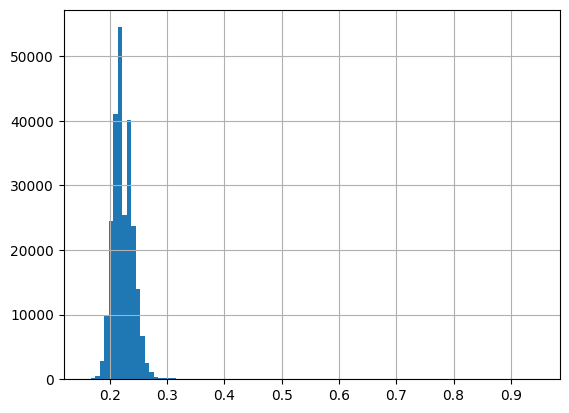

In [10]:
df.isna().mean(axis=1).hist(bins=100)

# 3 ALTERNATIVE; LAI to DB

In this step we will convert the LAI values to a timeseries of LAI values for each pixel OR field (extracted in the segmentation pipeline).
The conversion into timeseries will be done per image.

The values for each pixel or field will be stored in a database, which can be queried later on to extract the timeseries for a specific pixel or field.
This is done to limit the amount of data that has to be stored in memory and to facilitate continuous insertion of new data.

**Assumptions**:
- One has stored the EOPatch objects in a folder `$DATADIR` following the structure `DATADIR/lai_eopatch/lai_eopatch_{start_date}` (see step 1).

## Intermezzo: setting up the postgres database

### Step 1: Installing postgres on Ubuntu

Follow the instructions on this [link](https://www.postgresqltutorial.com/postgresql-getting-started/install-postgresql-linux/)

### Step 2: Creating the necessary users and databases

1. Login to postgres via the command line: 
```bash
sudo -i -u postgres psql
```
2. Create a new user `vista_user` with password `stelar`:
```sql
CREATE USER vista_user WITH PASSWORD 'stelar';
```
3. Create the database for this project named `stelar_vista` and grant read/write privileges to the user `stelar_vista:
```sql
CREATE DATABASE stelar_vista;
GRANT ALL ON DATABASE stelar_vista TO vista_user;
GRANT SELECT, INSERT, UPDATE ON ALL TABLES IN SCHEMA public TO vista_user;
```

## 3.1 LAI to DB: pixel values

**Process**:
The function `lai_to_db_px` will do the following:
For each image:
1. Load the LAI values.
2. Insert the LAI values in a PSQL database.

In [2]:
from src.dblib import drop_table, create_table, connect_to_db
from src.db.tables import LaiPxTable

with connect_to_db() as db:
    drop_table(db, LaiPxTable)
    create_table(db, LaiPxTable)

Connection successful to database 'stelar_vista'


In [2]:
def get_good_px_df(LAI: np.ndarray) -> pd.DataFrame:
    """
    Get all pixel coordinates and values with a valid LAI value
    """
    # Get all x,y coordinates as list of tuples
    x, y = np.meshgrid(np.arange(LAI.shape[0]), np.arange(LAI.shape[1]))
    x, y = x.flatten(), y.flatten()

    # Flatten the LAI array
    LAI = LAI.flatten()

    # Create dataframe
    df = pd.DataFrame({"x": x, "y": y, "LAI": LAI})

    # Get all good LAI values
    df = df[df["LAI"] > 0]

    return df

In [13]:
from src.dblib import connect_to_db
from src.db.tables import LaiPxTable

def insert_laipx_npy(npy_path:str, tile_id:str = "30TYQ"):
    POSTGRES_MAX = 500_000

    with connect_to_db() as db:
        # Create database first if necessary
        db.create_tables([LaiPxTable])

        # Load the npy file into memory
        LAI = np.load(npy_path)

        dtstr = os.path.basename(npy_path).replace(".npy", "")
        datetime = dt.datetime.strptime(dtstr, "%Y_%m_%d")

        # Insert the LAI values in bulk into the database
        print(f"Inserting LAI values for date {datetime}")

        # Get all good x,y coordinates and values
        pxdf = get_good_px_df(LAI)

        
        npartitions = int(np.ceil(len(pxdf) / POSTGRES_MAX))

        # Insert the good values in chunks of size POSTGRES_MAX
        for i,start in enumerate(range(0, len(pxdf), POSTGRES_MAX)):
            print(f"Inserting chunk {i+1}/{npartitions}", end="\r")

            localdf = pxdf.iloc[start:start+POSTGRES_MAX]

            # Add the datetime to the dataframe
            localdf["datetime"] = datetime

            # Add the tile_id to the dataframe
            localdf["tile_id"] = tile_id

            # Add the px_name to the dataframe
            localdf["px_name"] = localdf.tile_id + "_" + localdf.x.astype(str) + "_" + localdf.y.astype(str)

            # Get the chunk as a list of tuples
            rows = localdf.to_records(index=False).tolist()

            # Insert the values into the database
            fields = [LaiPxTable.datetime, LaiPxTable.tile_id, LaiPxTable.px_name, LaiPxTable.x, LaiPxTable.y, LaiPxTable.value]
            with db.atomic():
                LaiPxTable.insert_many(rows, fields=fields).execute()


In [14]:
DATADIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/VISTA/VISTA_code/data/segmentation_example"

npys = glob.glob(os.path.join(DATADIR, "LAI", "*.npy"))
npys.sort()

insert_laipx_npy(npys[0])

Connection successful to database 'stelar_vista'
Inserting LAI values for date 2020-01-06 00:00:00


/tmp/ipykernel_2832249/1940553901.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  localdf["datetime"] = datetime
/tmp/ipykernel_2832249/1940553901.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  localdf["tile_id"] = tile_id
/tmp/ipykernel_2832249/1940553901.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

KeyboardInterrupt: 